In [2]:

import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# from mpl_toolkits.basemap import Basemap
import glob
from netCDF4 import Dataset
import copy
import gc

import os
import sys
# sys.path.insert(0, '/Users/h/Github/geo_data_group/')
import grid_set as gs

import ant_plus
from imp import reload
reload(ant_plus)
reload(gs)

<module 'grid_set' from '/Users/h/PREMELT/Ant+/grid_set.py'>

In [48]:
#$### map projection
m = ccrs.SouthPolarStereo()
proj_cart = ccrs.PlateCarree() 
f = plt.figure()
G= gs.grid_set(m)

ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
G.set_grid_dxy(100e3,100e3,ax)
plt.close()


Got a grid res =  93  x  93
Note that all grid info is in nx x ny grids, whilst data is in nx x ny


In [4]:
# file = 'Example_Merge/Open_ocean_ANOM_2019-09-01T00-03_2019-09-03T23-26.nc'
# file = '/Users/h/PREMELT/Ant+/Comb_files_for_Stine/DOT_SLA_whole_anto_2019-03-01T00-40_2019-03-31T23-15.nc'
file = '/Users/h/PREMELT/Ant+/Comb_files_for_Stine/DOT_SLA_whole_anto_2019-09-01T00-03_2019-09-30T23-42.nc'
trackSAR=ant_plus.CS2_track(file,add_attr=True)
# track.print_time()

In [6]:
# file = 'Example_Merge/Open_ocean_ANOM_2019-09-01T00-03_2019-09-03T23-26.nc'
# file = '/Users/h/PREMELT/Ant+/Comb_files_for_Stine/DOT_SLA_whole_anto_2019-03-01T00-40_2019-03-31T23-15.nc'
file = '/Users/h/PREMELT/Ant+/SAR-SIN_comb/ST_and_range_ANOM_all_SARIN_2019-09-01T00-06_2019-09-30T23-41.nc'
trackSIN=ant_plus.CS2_track(file,add_attr=True)
# track.print_time()

In [7]:
### makes a directory for figures
fig_dir = file.split('T0')[0]
check_dir = os.path.dirname(fig_dir+'_SAR_SIN_comb/')
if not os.path.exists(check_dir):
    os.makedirs(check_dir)

In [9]:
trackSIN.list_vars()#['ANOM','flag',])

['time_20_ku',
 'lon_20_ku',
 'lat_20_ku',
 'range_1_20_ku',
 'flag_surf_type_class_20_ku',
 'height_1_20_ku',
 'mean_sea_surf_sea_ice_20_ku',
 'geoid_20_ku',
 'NSIDC_nasa',
 'atm_geo_corrections_sum_LEGOS_GPOD',
 'range_1_20_ku_ANOM_MSSL_D',
 'range_1_20_ku_ANOM_MSSL_S',
 'range_1_20_ku_ANOM_LEGOS_GPOD_All',
 'mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15',
 'mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU21',
 'atm_geo_corrections_sum_ANOM_LEGOS_GPOD']

In [10]:
load_list = trackSAR.list_vars(['ANOM','flag','height','geoid','mean_sea_surf_sea_ice_20_ku'])
# load_list = track.list_vars(['mean_sea_surf_sea_ice_20_ku'])
trackSAR.add_vars(load_list)

In [11]:
load_list = trackSIN.list_vars(['ANOM','flag','height','geoid','mean_sea_surf_sea_ice_20_ku'])
# load_list = track.list_vars(['mean_sea_surf_sea_ice_20_ku'])
trackSIN.add_vars(load_list)

In [12]:
# track.mean_sea_surf_20_ku_ANOM_DTU15_attr
# track.range_1_20_ku_ANOM_CLS_LEAD_attr
# track.flag_surf_type_class_20_ku_attr
trackSAR.mean_sea_surf_sea_ice_20_ku_attr

{'comment': 'Mean sea surface model, referenced to the WGS84 ellipsoid. This model has been optimised for use in computing the surface height anomaly of the polar oceans to derive sea-ice freeboard. The model is a merge of the CLS2011 mean sea-surface and CryoSat data from high latitudes.',
 'coordinates': 'lon_20_ku lat_20_ku',
 'institution': 'UCL',
 'long_name': 'mean sea surface height above reference ellipsoid',
 'source': 'UCL13',
 'standard_name': 'sea_surface_height_above_reference_ellipsoid',
 'units': 'm'}

In [13]:
trackSAR.range = '-'.join([
    ant_plus.CSt2dt(trackSAR.time_20_ku[0]).strftime('%Y%m%d'),
    ant_plus.CSt2dt(trackSAR.time_20_ku[-1]).strftime('%Y%m%d')])
trackSAR.range

'20190901-20190930'

In [14]:
trackSIN.range = '-'.join([
    ant_plus.CSt2dt(trackSIN.time_20_ku[0]).strftime('%Y%m%d'),
    ant_plus.CSt2dt(trackSIN.time_20_ku[-1]).strftime('%Y%m%d')])
trackSIN.range

'20190901-20190930'

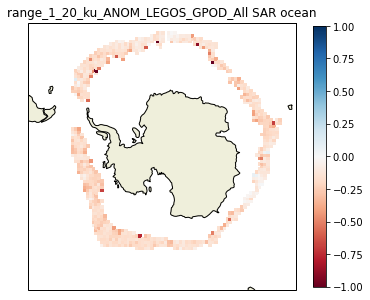

In [55]:
### recipe SLA
x = trackSAR.height_1_20_ku - trackSAR.mean_sea_surf_sea_ice_20_ku
#### options
hard_min = -10.0 ### extras to remove crazy outliers
hard_max =  10.0
h_min = -1.0
h_max =  1.0
### SAR - Ocean
#### anomaly ??
# v = 'range_1_20_ku_ANOM_ISat_2step'
vSl = 'range_1_20_ku_ANOM_LEGOS_GPOD_All'
xA = getattr(trackSAR,vSl).copy()
xA = x-xA
#### masking - OCEAN
msk = trackSAR.flag_surf_type_class_20_ku ==  64
x[x.mask] = np.nan
msk[xA>hard_max] = 0
msk[xA<hard_min] = 0
xA = xA[msk]
plot_SLA_SAR_O  = G.bin_list(xA,#trackSAR.mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15,
                            trackSAR.lon_20_ku[msk],trackSAR.lat_20_ku[msk],xy_order=0)
f = plt.figure(figsize=[6,6])
ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, -90, -50], proj_cart)
s = ax.pcolormesh(G.xpts,G.ypts,plot_SLA_SAR_O,
                 cmap = 'RdBu',vmin = h_min,vmax = h_max)
ax.set_title(vSl+' SAR ocean')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s,shrink=0.8,pad=0.05)
plt.show()

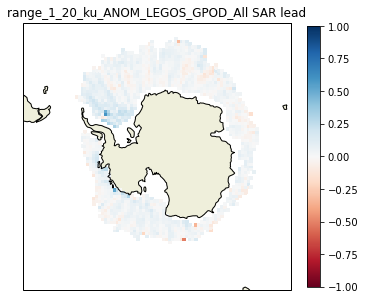

In [56]:
### recipe SLA
x = trackSAR.height_1_20_ku - trackSAR.mean_sea_surf_sea_ice_20_ku
#### options
hard_min = -10.0 ### extras to remove crazy outliers
hard_max =  10.0
h_min = -1.0
h_max =  1.0
### SAR - Lead
#### anomaly ??
# v = 'range_1_20_ku_ANOM_DTU_imp_th70'
vSo = 'range_1_20_ku_ANOM_LEGOS_GPOD_All'
xA = getattr(trackSAR,vSo).copy()
xA = x-xA
#### masking - LEADS
msk = trackSAR.flag_surf_type_class_20_ku == 256
x[x.mask] = np.nan
msk[xA>hard_max] = 0
msk[xA<hard_min] = 0
xA = xA[msk]
plot_SLA_SAR_L  = G.bin_list(xA,#trackSAR.mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15,
                            trackSAR.lon_20_ku[msk],trackSAR.lat_20_ku[msk],xy_order=0)
f = plt.figure(figsize=[6,6])
ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, -90, -50], proj_cart)
s = ax.pcolormesh(G.xpts,G.ypts,plot_SLA_SAR_L,
                 cmap = 'RdBu',vmin = h_min,vmax = h_max)
ax.set_title(vSo+' SAR lead')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s,shrink=0.8,pad=0.05)
plt.show()

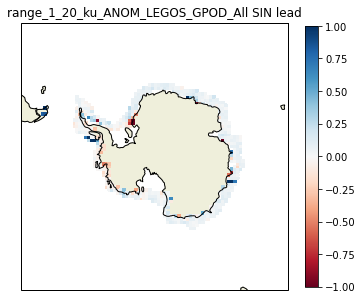

In [57]:
### recipe SLA
x = trackSIN.height_1_20_ku - trackSIN.mean_sea_surf_sea_ice_20_ku
#### options
hard_min = -10.0 ### extras to remove crazy outliers
hard_max =  10.0
h_min = -1.0
h_max =  1.0
### SIN - Lead
#### anomaly ??
vSIN = 'range_1_20_ku_ANOM_LEGOS_GPOD_All'
xA = getattr(trackSIN,vSIN).copy()
xA = x-xA
#### masking - LEADS
msk = trackSIN.flag_surf_type_class_20_ku == 272
x[x.mask] = np.nan
msk[xA>hard_max] = 0
msk[xA<hard_min] = 0
xA = xA[msk]
plot_SLA_SIN_L  = G.bin_list(xA,#trackSIN.mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15,
                            trackSIN.lon_20_ku[msk],trackSIN.lat_20_ku[msk],xy_order=0)
f = plt.figure(figsize=[6,6])
ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, -90, -50], proj_cart)
s = ax.pcolormesh(G.xpts,G.ypts,plot_SLA_SIN_L,
                 cmap = 'RdBu',vmin = h_min,vmax = h_max)
ax.set_title(vSIN+' SIN lead')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s,shrink=0.8,pad=0.05)
plt.show()

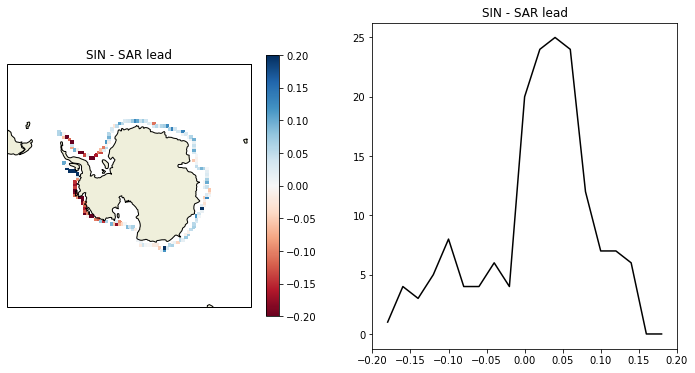

In [58]:
h_min = -0.2
h_max =  0.2
f = plt.figure(figsize=[12,6])
ax = f.add_subplot(1,2,1,projection=m)
ax.set_extent([-180, 180, -90, -50], proj_cart)
s = ax.pcolormesh(G.xpts,G.ypts,plot_SLA_SIN_L-plot_SLA_SAR_L,
                 cmap = 'RdBu',vmin = h_min,vmax = h_max)
ax.set_title('SIN - SAR lead')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s,shrink=0.8,pad=0.05)

##### HISTOGRAM
bin_no = 20
h_bins = np.arange(h_min,h_max,(h_max-h_min)/bin_no)
hist = np.histogram(plot_SLA_SIN_L-plot_SLA_SAR_L,bins=h_bins)[0]
ax = f.add_subplot(1,2,2)
ax.plot(h_bins[:-1] + np.diff(h_bins),hist,'-k')
ax.set_xlim([h_min,h_max])
ax.set_title('SIN - SAR lead')
plt.show()
f.savefig(fig_dir+vSIN+'_to_'+vSl+'.png')

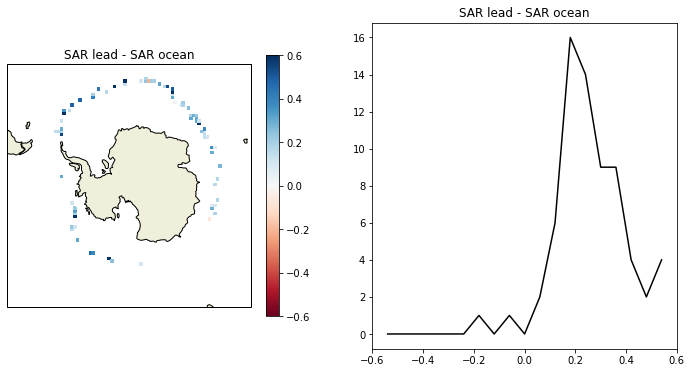

In [53]:
h_min = -0.6
h_max =  0.6
f = plt.figure(figsize=[12,6])
ax = f.add_subplot(1,2,1,projection=m)
ax.set_extent([-180, 180, -90, -50], proj_cart)
s = ax.pcolormesh(G.xpts,G.ypts,plot_SLA_SAR_L-plot_SLA_SAR_O,
                 cmap = 'RdBu',vmin = h_min,vmax = h_max)
ax.set_title('SAR lead - SAR ocean')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
plt.colorbar(s,shrink=0.8,pad=0.05)

##### HISTOGRAM
bin_no = 20
h_bins = np.arange(h_min,h_max,(h_max-h_min)/bin_no)
hist = np.histogram(plot_SLA_SAR_L-plot_SLA_SAR_O,bins=h_bins)[0]
ax = f.add_subplot(1,2,2)
ax.plot(h_bins[:-1] + np.diff(h_bins),hist,'-k')
ax.set_xlim([h_min,h_max])
ax.set_title('SAR lead - SAR ocean')
plt.show()
f.savefig(fig_dir+vSl+'_to_'+vSl+'.png')

In [33]:
for v in trackSAR.vars:
    if 'range' in v and 'ANOM' in v:
#     if 'range' in v and 'ISat' in v:
#     if 'geoi' in v:
#     if 'ANOM' in v:
        print('-----')
        print(v)
        print('-----')
        if hasattr(trackSAR,v+'_attr'):
            attr = getattr(trackSAR,v+'_attr')
            for key, value in attr.items():
                print(key, ' : ', value)
        x = copy.copy(getattr(trackSAR,v))
        if type(x.mask) == np.ndarray:
            x[x.mask] = np.nan
        print('Distribution of '+v+' = '+' , '.join('{:.3}'.format(pc) for pc in np.nanpercentile(x,[25,50,75])))

-----
range_1_20_ku_ANOM_ISat_2step
-----
Description  :  Anomaly from L2 range to _ISat_2step retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_ISat_2step = 0.0959 , 0.188 , 0.304
-----
range_1_20_ku_ANOM_ISat_SWH_MSSfixed_Ice
-----
Description  :  Anomaly from L2 range to _ISat_SWH_MSSfixed_Ice retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_ISat_SWH_MSSfixed_Ice = -0.142 , 0.0368 , 0.292
-----
range_1_20_ku_ANOM_DTU_imp_th70
-----
Description  :  Anomaly from L2 range to _DTU_imp_th70 retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_DTU_imp_th70 = -0.492 , -0.239 , -0.185
-----
range_1_20_ku_ANOM_DTU_th70
-----
Description  :  Anomaly from L2 range to _DTU_th70 retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_DTU_th70 = -0.00793 , 0.0485 , 0.106
-

In [34]:
for v in trackSIN.vars:
    if 'range' in v and 'ANOM' in v:
#     if 'range' in v and 'ISat' in v:
#     if 'geoi' in v:
#     if 'ANOM' in v:
        print('-----')
        print(v)
        print('-----')
        if hasattr(trackSIN,v+'_attr'):
            attr = getattr(trackSIN,v+'_attr')
            for key, value in attr.items():
                print(key, ' : ', value)
        x = copy.copy(getattr(trackSIN,v))
        if type(x.mask) == np.ndarray:
            x[x.mask] = np.nan
        print('Distribution of '+v+' = '+' , '.join('{:.3}'.format(pc) for pc in np.nanpercentile(x,[25,50,75])))

-----
range_1_20_ku_ANOM_MSSL_D
-----
Description  :  Anomaly from L2 range to _MSSL_D retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_MSSL_D = -0.101 , -0.056 , -0.021
-----
range_1_20_ku_ANOM_MSSL_S
-----
Description  :  Anomaly from L2 range to _MSSL_S retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_MSSL_S = 0.144 , 0.236 , 0.439
-----
range_1_20_ku_ANOM_LEGOS_GPOD_All
-----
Description  :  Anomaly from L2 range to _LEGOS_GPOD_All retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_LEGOS_GPOD_All = 0.011 , 0.297 , 2.39
